In [21]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import opinion_lexicon
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
nltk.download('opinion_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


True

In [3]:
# Load the cleaned datasets
reviews = pd.read_parquet('data/review_Cell_Phones_and_Accessories.parquet')
metadata = pd.read_parquet('data/metadata_Cell_Phones_and_Accessories.parquet')

# Merge the datasets on 'asin' and 'parent_asin'
merged_data = pd.merge(reviews, metadata, on=['parent_asin'], how='inner')

In [4]:
merged_data

,rating,title_x,text,asin,parent_asin,timestamp,helpful_vote,verified_purchase,main_category,title_y,...,rating_number,features,description,price,store,categories,details,bought_together,subtitle,author
0,4.0,Decent,Lasted about 9 months then the lock button bro...,B07XRDHDNQ,B07XRDHDNQ,1590470082910,0,True,Amazon Home,TORRAS COOLIFY Zone 7 Midnight Green,...,2725,[[Ultra-Thin yet Protective]: iPhone 11 pro sl...,[],None,TORRAS,"[Cell Phones & Accessories, Cases, Holsters & ...","{""Product Dimensions"": ""6.93 x 3.78 x 0.63 inc...",None,None,None
1,5.0,Same green as iPhone 11pro,The case is a lovely green iridescent color th...,B07XRDHDNQ,B07XRDHDNQ,1584201027802,0,True,Amazon Home,TORRAS COOLIFY Zone 7 Midnight Green,...,2725,[[Ultra-Thin yet Protective]: iPhone 11 pro sl...,[],None,TORRAS,"[Cell Phones & Accessories, Cases, Holsters & ...","{""Product Dimensions"": ""6.93 x 3.78 x 0.63 inc...",None,None,None
2,5.0,Must buy for a sleek and simple look.,Product fits great and looks great. Offers dec...,B07XRDHDNQ,B07XRDHDNQ,1578858495171,0,True,Amazon Home,TORRAS COOLIFY Zone 7 Midnight Green,...,2725,[[Ultra-Thin yet Protective]: iPhone 11 pro sl...,[],None,TORRAS,"[Cell Phones & Accessories, Cases, Holsters & ...","{""Product Dimensions"": ""6.93 x 3.78 x 0.63 inc...",None,None,None
3,2.0,Poor quality,Color is fading after 3 month and coming small...,B07XRDHDNQ,B07XRDHDNQ,1596947362802,0,True,Amazon Home,TORRAS COOLIFY Zone 7 Midnight Green,...,2725,[[Ultra-Thin yet Protective]: iPhone 11 pro sl...,[],None,TORRAS,"[Cell Phones & Accessories, Cases, Holsters & ...","{""Product Dimensions"": ""6.93 x 3.78 x 0.63 inc...",None,None,None
4,3.0,Midnight green paint chips very easily,I had a Torras slim case for my iPhone XS whic...,B07XRDHDNQ,B07XRDHDNQ,1583709758238,0,True,Amazon Home,TORRAS COOLIFY Zone 7 Midnight Green,...,2725,[[Ultra-Thin yet Protective]: iPhone 11 pro sl...,[],None,TORRAS,"[Cell Phones & Accessories, Cases, Holsters & ...","{""Product Dimensions"": ""6.93 x 3.78 x 0.63 inc...",None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2742491,1.0,Doesn’t charge,After it wouldn’t charge my phone (with a case...,B0BR7WCT34,B0BR7WCT34,1683088615757,0,True,Industrial & Scientific,KPON Travel Charger for iPhone and Apple Watch...,...,86,[【Travel Wireless Charger】This 3 in 1 wireless...,[],None,KPON,"[Cell Phones & Accessories, Accessories, Smart...","{""Package Dimensions"": ""7.44 x 3.58 x 0.75 inc...",None,None,None
2742492,5.0,So nice,It is a compact and usefull thing.,B0B8ZQ4VJ4,B0B8ZQ4VJ4,1675207523649,0,True,All Electronics,"35W Dual Charger for iPhone, MacBook Air, iPad...",...,65,[35W Fast Charger: Charging iPhone 14 Pro Max ...,[],None,IFEART,"[Cell Phones & Accessories, Accessories, Charg...","{""Product Dimensions"": ""2.01 x 0.83 x 2.05 inc...",None,None,None
2742493,5.0,Superb quality.. great product,Great quality . 5 stars!!!,B0B2D33R45,B0B2D33R45,1661134284407,0,True,Cell Phones & Accessories,"GBEAST Phone Mount for Car, Vent Car Phone Hol...",...,41,[Enjoy the Comfort of Never Blocking: The car ...,[],None,GBEAST,"[Cell Phones & Accessories, Accessories, Autom...","{""Product Dimensions"": ""2.56 x 4.92 x 5.12 inc...",None,None,None
2742494,1.0,Buyers beware!,It is cheaply made and takes forever to charge...,B0B68XS37Y,B0B68XS37Y,1678652930056,0,True,All Electronics,Lopnord 3 in 1 Charging Station for Multiple D...,...,44,[🔋【3 IN 1 CHARGER STATION】Lopnord Charging sta...,[],25.99,Lopnord,"[Cell Phones & Accessories, Accessories, Charg...","{""Package Dimensions"": ""7.32 x 4.65 x 2.68 inc...",None,None,None


# Amazon rating

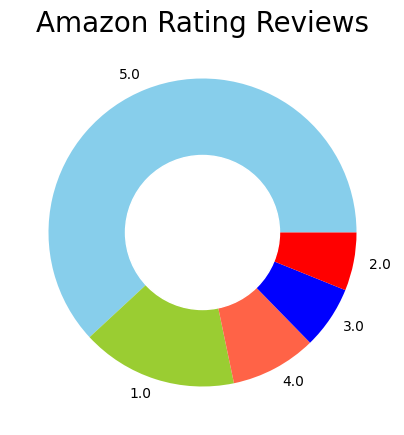

In [5]:
ratings = merged_data["rating"].value_counts()
number = ratings.index
quantity = ratings.values 

custom_colors = ["skyblue", "yellowgreen", 'tomato', "blue", "red"]
plt.figure(figsize=(5, 5))
plt.pie(quantity, labels=number, colors=custom_colors)
central_circle = plt.Circle((0, 0), 0.5, color='white')
fig = plt.gcf()
fig.gca().add_artist(central_circle)
plt.rc('font', size=12)
plt.title("Amazon Rating Reviews", fontsize=20)
plt.show()

# Sentiment distribution for all the reviews

In [6]:
# Sentiment Analysis
sid = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    """Analyze sentiment of the given text."""
    scores = sid.polarity_scores(text)
    return scores['compound']

# Apply sentiment analysis to the review text
merged_data['sentiment_score'] = merged_data['text'].apply(analyze_sentiment)

# Categorize sentiment
merged_data['sentiment_category'] = pd.cut(
    merged_data['sentiment_score'], 
    bins=[-1, -0.1, 0.1, 1], 
    labels=['Negative', 'Neutral', 'Positive']
)

c:\Users\LENOVO\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


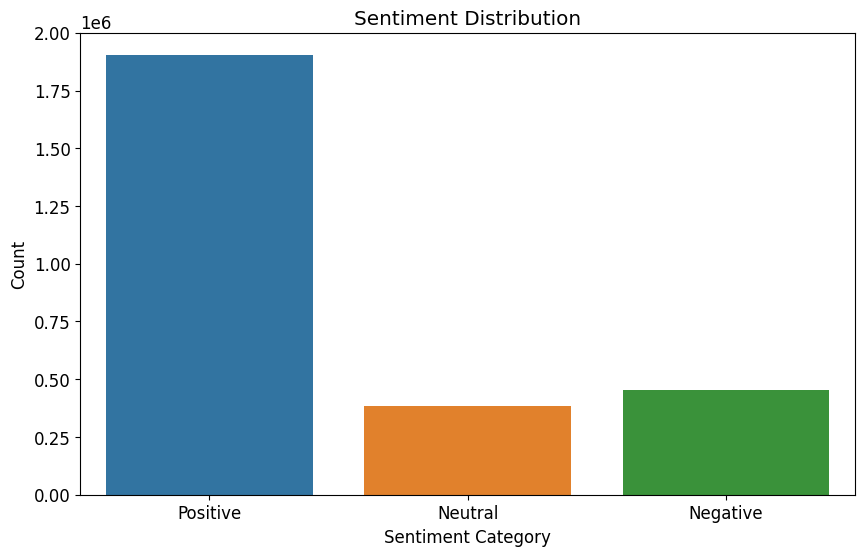

In [7]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(10, 6))
sns.countplot(data=merged_data, x='sentiment_category', order=['Positive', 'Neutral', 'Negative'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.show()

# Sentiment distribution for top 12 products (with the highest reviews)

c:\Users\LENOVO\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\LENOVO\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\LENOVO\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning

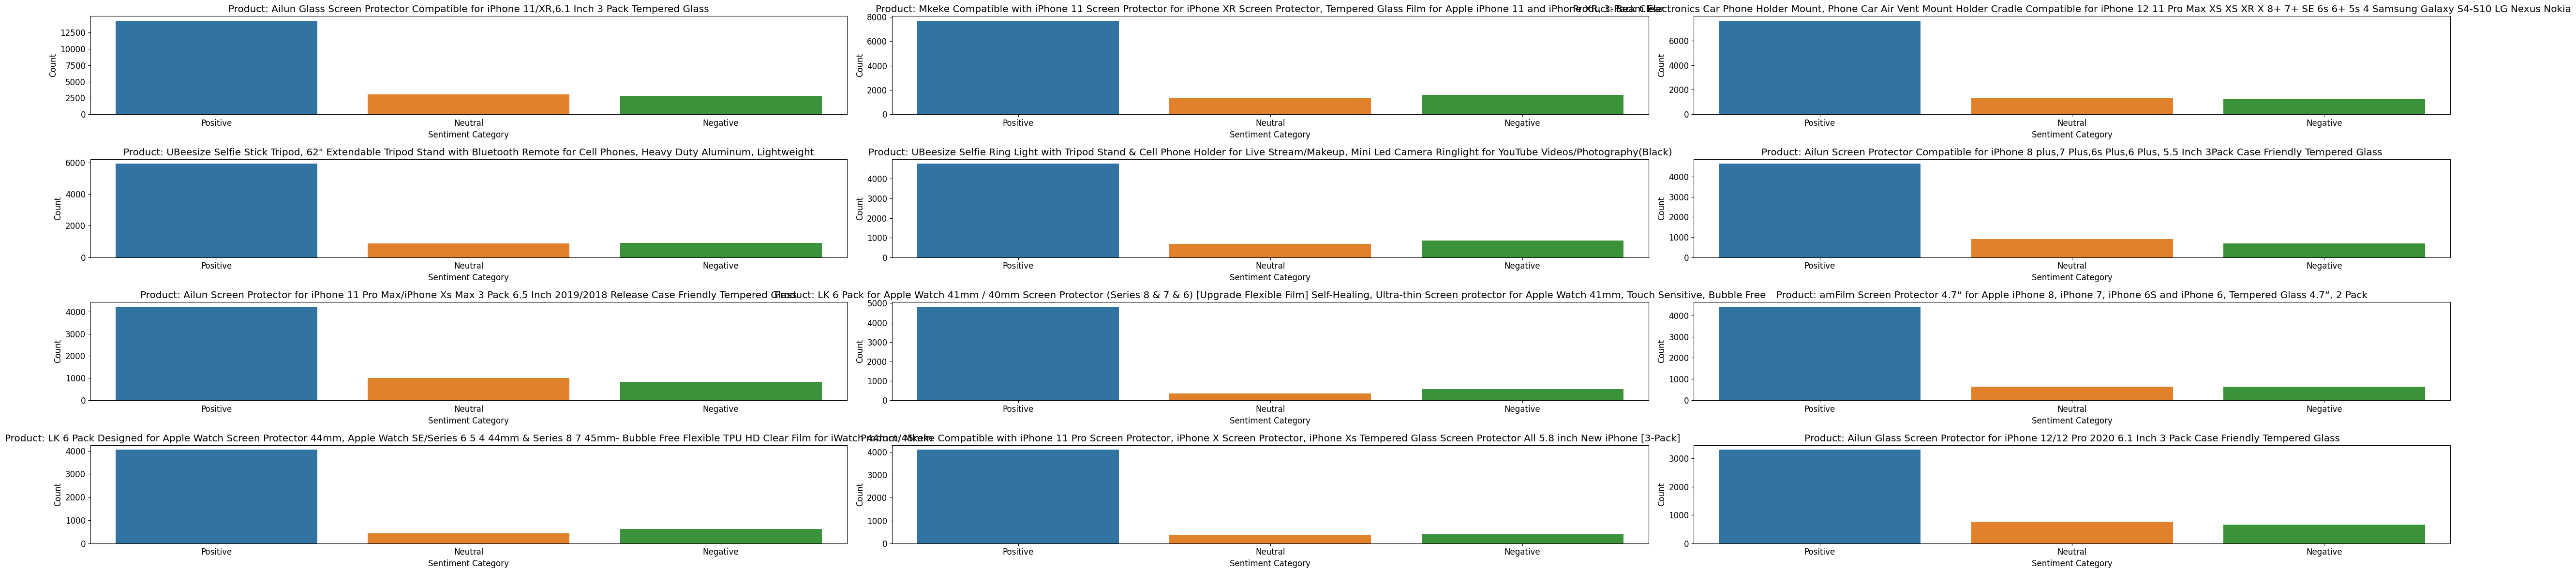

In [8]:
# Group data by 'parent_asin'
grouped_data = merged_data.groupby('parent_asin')

# Function to plot sentiment distribution for multiple products using subplots
def plot_sentiment_distributions(products, metadata, n_per_row=3):
    n_products = len(products)
    n_rows = (n_products // n_per_row) + (n_products % n_per_row > 0)
    
    fig, axes = plt.subplots(n_rows, n_per_row, figsize=(50, n_rows * 3))
    axes = axes.flatten()  # Flatten the axes array for easy iteration
    
    for i, product_asin in enumerate(products):
        product_data = merged_data[merged_data['parent_asin'] == product_asin]
        product_title = metadata.loc[metadata['parent_asin'] == product_asin, 'title'].values[0] if not metadata.empty else product_asin
        
        sns.countplot(data=product_data, x='sentiment_category', order=['Positive', 'Neutral', 'Negative'], ax=axes[i])
        axes[i].set_title(f'Product: {product_title}')
        axes[i].set_xlabel('Sentiment Category')
        axes[i].set_ylabel('Count')
    
    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

top_products = merged_data['parent_asin'].value_counts().head(12).index
plot_sentiment_distributions(top_products, metadata)

# Word Cloud for Positive and Negative Reviews

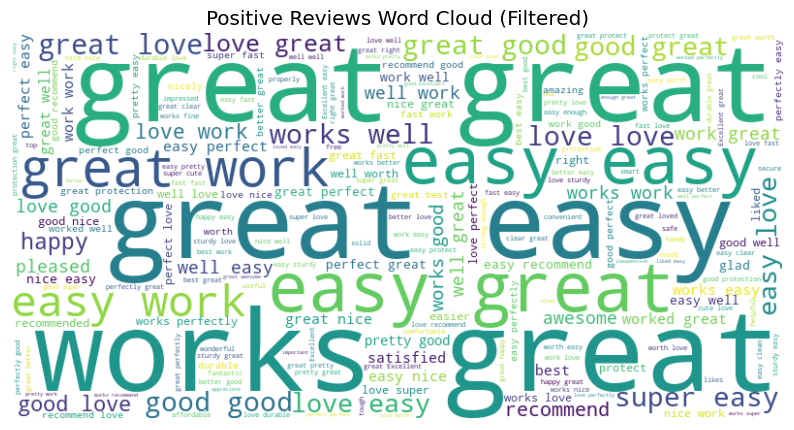

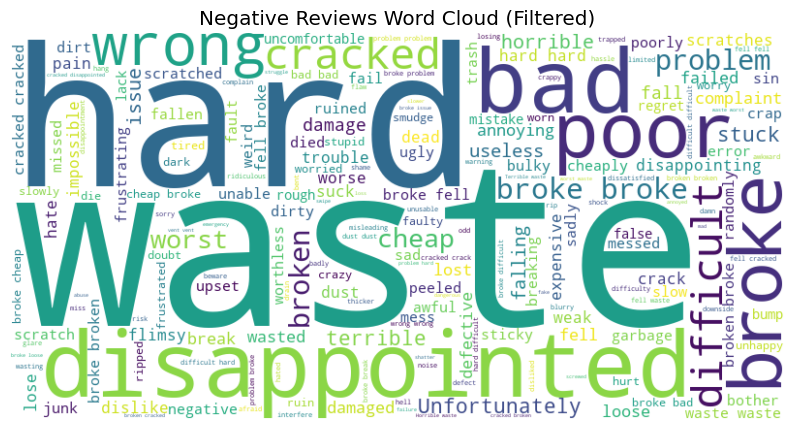

In [9]:
# Get a list of positive and negative words from the lexicon
positive_words_set = set(opinion_lexicon.positive())
negative_words_set = set(opinion_lexicon.negative())

def filter_positive_words(text):
    """Filter only positive words from the text."""
    words = text.split()
    return " ".join(word for word in words if word.lower() in positive_words_set)

def filter_negative_words(text):
    """Filter only negative words from the text."""
    words = text.split()
    return " ".join(word for word in words if word.lower() in negative_words_set)

def plot_wordcloud_filtered(data, sentiment_category, filter_positive=False, filter_negative=False):
    """Generate a word cloud for the specified sentiment category."""
    text = " ".join(data[data['sentiment_category'] == sentiment_category]['text'].fillna(""))
    if filter_positive:
        text = filter_positive_words(text)  # Filter for positive words
    if filter_negative:
        text = filter_negative_words(text)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{sentiment_category} Reviews Word Cloud (Filtered)' if filter_positive or filter_negative else f'{sentiment_category} Reviews Word Cloud')
    plt.show()

# Example Usage:
#Assuming `merged_data` is a DataFrame with columns 'sentiment_category' and 'text'
plot_wordcloud_filtered(merged_data, 'Positive', filter_positive=True)  # Positive words only
plot_wordcloud_filtered(merged_data, 'Negative', filter_negative=True)  

# Top 10 Products with the most Negative Reviews

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_10048\3581538710.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_data.groupby(['parent_asin', 'sentiment_category'])


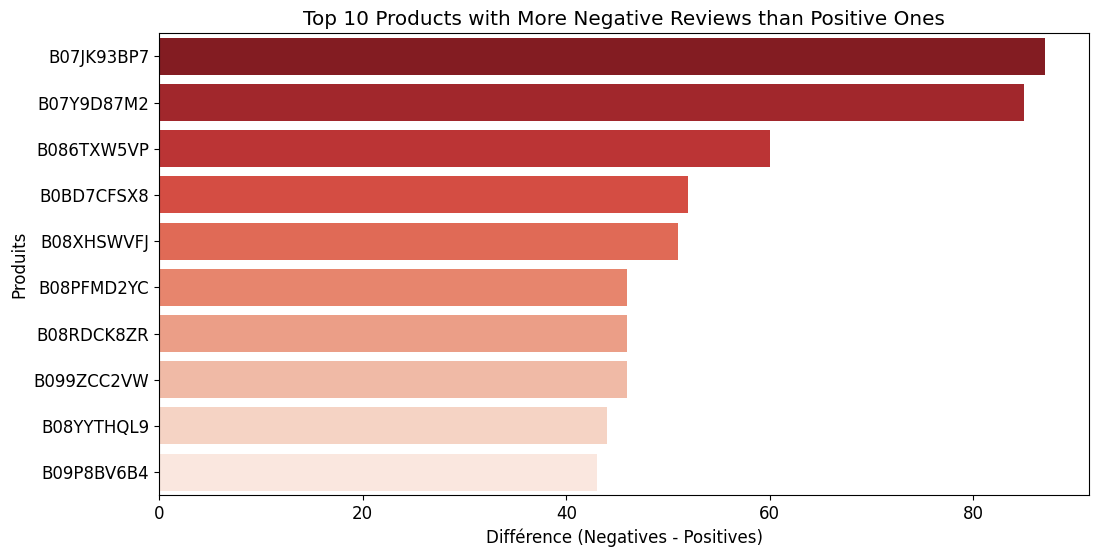

In [10]:
sentiment_counts = (
    merged_data.groupby(['parent_asin', 'sentiment_category'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

sentiment_counts['negative_more_than_positive'] = (
    sentiment_counts.get('Negative', 0) - sentiment_counts.get('Positive', 0)
)

top_negative_products = (
    sentiment_counts.sort_values(by='negative_more_than_positive', ascending=False)
    .head(10)
)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_negative_products,
    x='negative_more_than_positive',
    y='parent_asin',
    palette='Reds_r',
)
plt.title('Top 10 Products with More Negative Reviews than Positive Ones')
plt.xlabel('Différence (Negatives - Positives)')
plt.ylabel('Produits')
plt.show()

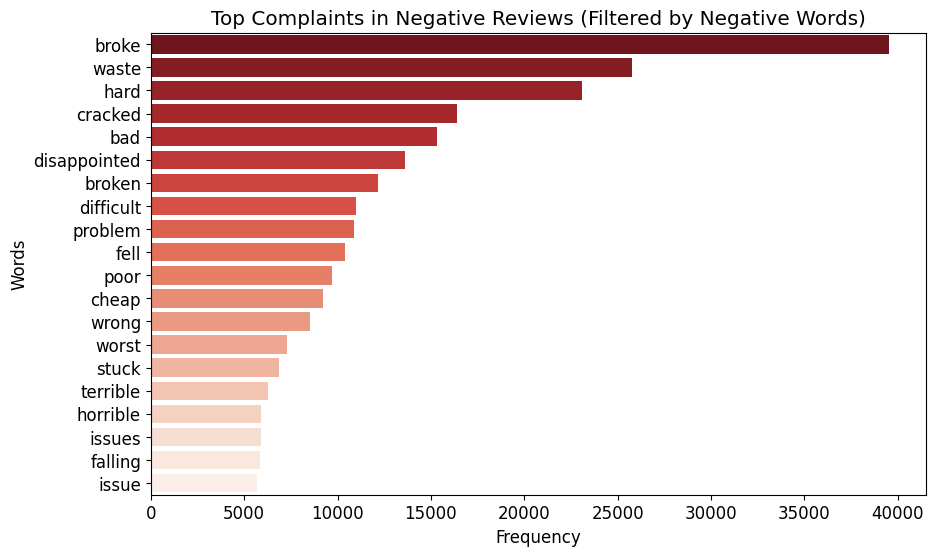

In [14]:
# Get a list of negative words from the lexicon
negative_words_set = set(opinion_lexicon.negative())

def filter_negative_words(text):
    """Filter only negative words from the text."""
    words = text.split()
    return [word.lower() for word in words if word.lower() in negative_words_set]

# Filter words to include only those with negative meanings
text = " ".join(merged_data[merged_data['sentiment_category'] == "Negative"]['text'].fillna(""))
filtered_words = filter_negative_words(text)

# Count the frequency of negative words
if filtered_words:
    word_counts = Counter(filtered_words)
    word_freq_df = pd.DataFrame(word_counts.items(), columns=['word', 'frequency']).sort_values(by='frequency', ascending=False)
    
    # Plot the top complaints with negative meanings
    plt.figure(figsize=(10, 6))
    sns.barplot(data=word_freq_df.head(20), x='frequency', y='word', palette='Reds_r')
    plt.title('Top Complaints in Negative Reviews (Filtered by Negative Words)')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.show()
else:
    print("No negative words found in the dataset.")

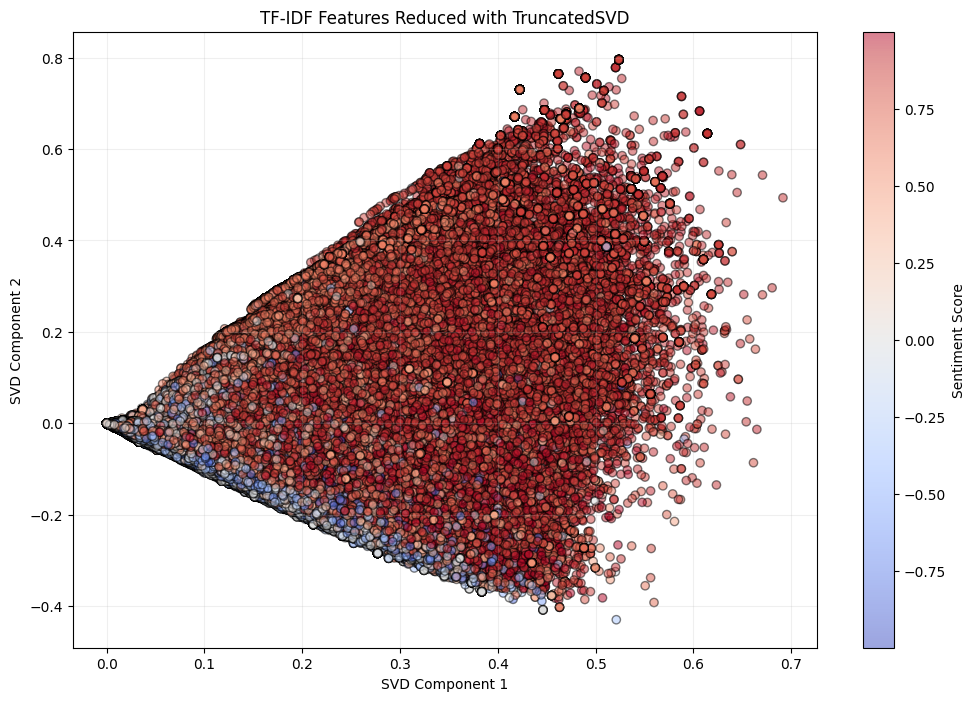

In [12]:
from sklearn.decomposition import TruncatedSVD

# Dimensionality Reduction with TruncatedSVD
svd = TruncatedSVD(n_components=2, random_state=42)
reduced_tfidf = svd.fit_transform(tfidf_matrix)

# Scatter Plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    reduced_tfidf[:, 0], reduced_tfidf[:, 1],
    c=merged_data['sentiment_score'], cmap='coolwarm', alpha=0.5, edgecolors='k'
)
plt.colorbar(scatter, label='Sentiment Score')
plt.title('TF-IDF Features Reduced with TruncatedSVD')
plt.xlabel('SVD Component 1')
plt.ylabel('SVD Component 2')
plt.grid(alpha=0.2)
plt.show()
